# Dynamic Programming for Reinforcement Learning

This notebook tries out the concepts explained in Chapter 4 of the book [Reinforcement Learning: An Introduction - Sutton & Barto](https://www.goodreads.com/book/show/739791.Reinforcement_Learning). 


In [23]:
import matplotlib.pyplot as plt
import numpy as np

def draw_grid(value): 
    fig, ax = plt.subplots(figsize=(3, 2))
    ax.axis('tight')
    ax.axis('off')
    
    # Create table
    table = ax.table(cellText=value, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(2, 2)
    
    # Style the cells
    for i in range(len(value)):
        for j in range(len(value[0])):
            cell = table[(i, j)]
            cell.set_facecolor('#f0f0f0')
            cell.set_edgecolor('black')
            cell.set_linewidth(1)
    
    plt.show()

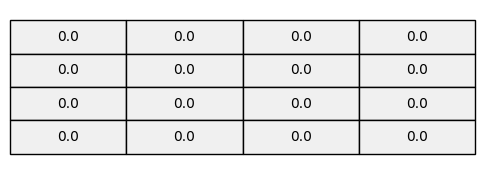

In [26]:
def init_value_function(grid_size):
    """Initialize the value function to all zeros for every cell"""
    value_function = np.zeros(grid_size)
    return value_function

draw_grid(init_value_function((4, 4)))

In [27]:
from typing import Tuple


def get_next_state(state, action, grid_size):
    """Get the next state given the current state and action"""
    x, y = state
    if action == 'up' and x > 0:
        x -= 1
    elif action == 'down' and x < grid_size[0] - 1:
        x += 1
    elif action == 'left' and y > 0:
        y -= 1
    elif action == 'right' and y < grid_size[1] - 1:
        y += 1
    return (x, y)

def get_reward(state, grid_size) -> Tuple[int, int]:
    """Get the reward for moving to a state
    
    Returns 0 if the state is one of the target states, else -1.
    Target States are hard coded: they are (0, 0) and (grid_size[0]-1, grid_size[1]-1)
    
    Args: 
        state: tuple (x, y) representing the current state
        grid_size: tuple (rows, cols) representing the size of the grid
        
    Returns:
        A tuple (probability of the reward, reward value)
    """
    return (1, 0 if state in [(0, 0), (grid_size[0]-1, grid_size[1]-1)] else -1)

In [47]:
def state_value_k(state, values_km1, policy, grid_size): 
    """Calculates the value of the state at iteration k under the policy
    
    Args:
        state: current state indicated as a tuple (row, column)
        values_km1: value function at iteration k-1
        policy: policy matrix indicating action probabilities for each state. It's a 4x4x4 matrix
        grid_size: tuple (rows, cols) representing the size of the grid
    """
    # value of a terminal state is always 0
    if state in [(0, 0), (grid_size[0]-1, grid_size[1]-1)]:
        return 0
    
    # For each action, multiply the probability of taking that action by the value of choosing that action in the state
    action_values = []
    for (action_i, action) in enumerate(['up', 'down', 'left', 'right']):
        action_prob = policy[state[0]][state[1]][action_i]
        
        # For each state reachable from the current state with that action, get the value
        next_state = get_next_state(state, action, grid_size)
        (reward_prob, reward) = get_reward(next_state, grid_size) # Reward is a tuple (probability, value of reward)
        next_state_value = values_km1[next_state[0]][next_state[1]]
        
        value = action_prob * reward_prob * (reward + next_state_value)
        
        action_values.append(value)
        
    return sum(action_values)
    

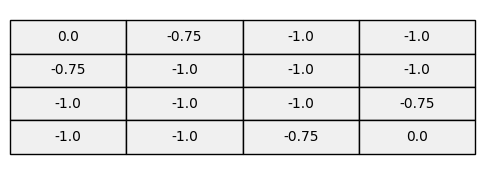

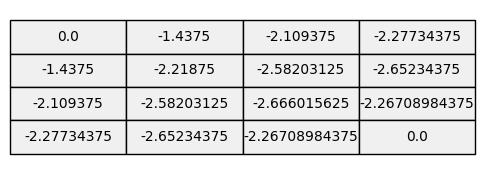

In [ ]:
grid_size = (4, 4)
policy = np.full((grid_size[0], grid_size[1], 4), 0.25)  # Uniform random policy
initial_states = init_value_function(grid_size)

state_values = np.zeros(grid_size)
for state_i in range(grid_size[0]):
    for state_j in range(grid_size[1]):
        state = (state_i, state_j)
        svk = state_value_k(state, initial_states, policy=policy, grid_size=grid_size)
        
        state_values[state_i][state_j] = svk

draw_grid(state_values)

state_values_2 = np.copy(state_values)
for state_i in range(grid_size[0]):
    for state_j in range(grid_size[1]):
        state = (state_i, state_j)
        svk = state_value_k(state, state_values_2, policy=policy, grid_size=grid_size)
        
        state_values_2[state_i][state_j] = svk

draw_grid(state_values_2)

In [ ]:
def iterative_policy_eval(policy, states, gamma): 
    """Evaluates the given policy on all the states. 
    Each cell in the grid represents in the state. 
    The value in the cell represents the value of that state under the provided policy.
    
    Utilizes DP to compute appximate the value function using the Bellman expectation equation and iterative updates.
    
    Args:
        policy: A function that takes in a state and returns the probability of each action to take in that state.
        states: A matrix (4x4) representing the states in the grid.
        gamma: Discount factor for future rewards.
    """
    k = 1  # iteration counter. k = 0 is the initialization step (states provided)
    max_k = 10
    
    v = [np.zeros_like(states) for _ in range(max_k + 1)]  # value function for each iteration
    
    while k < max_k: 
        # Calculate the expected value of each state under the policy
        
        
    